In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Modeling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor 
import warnings
# warnings.filterwarnings('ignore')

In [2]:
import sklearn
print(sklearn.__version__)

1.7.1


In [ ]:
file = "data/eq_maintenance_updated_data.csv"
df = pd.read_csv(file)
df.head(1)

,equipment_id,equipment_type,location,install_date,last_service_date,next_scheduled_service,age_days,runtime_hours,temperature,vibration_level,power_consumption_kw,humidity_level,error_codes_count,manual_override,downtime_last_30d,service_priority,failure_within_7_days
0,dda080ad-7ead-4676-92e2-b6d818addfcc,HVAC,Building A,2023-08-04,2024-01-26,2024-03-31,742,5496.71,73.62,3.97,27.62,39.36,0,0,0.12,Medium,0


#### Prpairing X and Y 

In [32]:
X = df.drop(columns=('failure_within_7_days'), axis=1)

In [33]:
y = df['failure_within_7_days']

In [34]:
# print("Categories in 'equipment_id' variable:     ",end=" " )
# print(df['equipment_id'].unique())

print("Categories in 'equipment_type' variable:  ",end=" ")
print(df['equipment_type'].unique())

print("Categories in'location' variable:",end=" " )
print(df['location'].unique())

print("Categories in 'install_date' variable:     ",end=" " )
print(df['install_date'].unique())

print("Categories in 'last_service_date' variable:     ",end=" " )
print(df['last_service_date'].unique())

print("Categories in 'next_scheduled_service' variable:     ",end=" " )
print(df['next_scheduled_service'].unique())

print("Categories in 'service_priority' variable:     ",end=" " )
print(df['service_priority'].unique())

Categories in 'equipment_type' variable:   ['HVAC' 'Boiler' 'Elevator' 'Generator' 'Pump']
Categories in'location' variable: ['Building A' 'Building C' 'Building B' 'Warehouse 2' 'Warehouse 1']
Categories in 'install_date' variable:      ['2023-08-04' '2022-12-26' '2022-11-14' '2023-11-11' '2024-06-14'
 '2021-09-06' '2022-10-31' '2023-09-19' '2021-04-11' '2023-07-17'
 '2023-05-13' '2021-09-11' '2024-02-29' '2021-09-04' '2022-08-07'
 '2020-11-17' '2023-05-08' '2022-06-10' '2023-12-28' '2024-06-08'
 '2024-02-20' '2020-12-19' '2021-04-14' '2022-03-22' '2021-08-13'
 '2023-06-16' '2021-07-30' '2022-07-07' '2022-04-27' '2021-08-14'
 '2021-08-16' '2024-07-01' '2024-01-31' '2024-04-30' '2021-03-30'
 '2022-12-17' '2024-01-11' '2022-12-09' '2021-11-21' '2022-06-15'
 '2020-12-01' '2022-02-07' '2023-04-18' '2021-03-31' '2022-07-30'
 '2020-08-21' '2022-11-13' '2021-03-20' '2021-06-19' '2023-08-15'
 '2020-09-21' '2021-04-06' '2023-11-21' '2021-12-08' '2021-12-13'
 '2021-01-21' '2022-03-02' '2024-04-

In [35]:
# Create columns transformer with 3 types of transformers

num_feautres = X.select_dtypes(exclude=['object']).columns
cat_features = X.select_dtypes(include=['object']).columns  

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer   
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        
        ('OneHotEncoder', oh_transformer, cat_features),
        ('StandardScaler', numeric_transformer, num_feautres)
    ],
    remainder='passthrough'
)

In [36]:
X = preprocessor.fit_transform(X)

In [37]:
# Separate the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 3130), (200, 3130), (800,), (200,))

#### Create an evaluation function to give all matrix after model training

In [40]:
def evaluate_model(true, predicted) :
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    
    return mae, rmse, r2

In [44]:
models = {
    "LinearRegression": LinearRegression(),
    "KNeighborsRegressor": KNeighborsRegressor(),   
    "Lasso": sklearn.linear_model.Lasso(),
    "Ridge": sklearn.linear_model.Ridge(),
    "DecissionTree": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),   
    "XGBRegressor": XGBRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose=0),
    "adaboost": sklearn.ensemble.AdaBoostRegressor(),
    # "SVR": SVR()  # Support Vector Regressor
    }
model_list = []
r2_list = []
for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train the model

    # Make a prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #Evaluate Train and Test dataset
    # model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print("--------------------------------------------------")
    print(list(models.keys())[i]) 
    model_list.append(list(models.keys())[i])

    print('Model Performance on TRaining Data')
    print("_ Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("_ Mean Absolute Error: {:.4f}".format(model_train_mae))  
    print("_ R2 Score: {:.4f}".format(model_train_r2))

    print("--------------------------------------------------")
    print("Model performance on Test Data")
    print("_ Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("_ Mean Absolute Error: {:.4f}".format(model_test_mae)) 
    print("_ R2 Score: {:.4f}".format(model_test_r2)) 

    r2_list.append(model_test_r2)
    print('=' *35)
    print('\n')


--------------------------------------------------
LinearRegression
Model Performance on TRaining Data
_ Root Mean Squared Error: 0.0000
_ Mean Absolute Error: 0.0000
_ R2 Score: 1.0000
--------------------------------------------------
Model performance on Test Data
_ Root Mean Squared Error: 0.2413
_ Mean Absolute Error: 0.1306
_ R2 Score: 0.0417


--------------------------------------------------
KNeighborsRegressor
Model Performance on TRaining Data
_ Root Mean Squared Error: 0.1586
_ Mean Absolute Error: 0.0453
_ R2 Score: 0.3988
--------------------------------------------------
Model performance on Test Data
_ Root Mean Squared Error: 0.2168
_ Mean Absolute Error: 0.0630
_ R2 Score: 0.2267


--------------------------------------------------
Lasso
Model Performance on TRaining Data
_ Root Mean Squared Error: 0.2045
_ Mean Absolute Error: 0.0837
_ R2 Score: 0.0000
--------------------------------------------------
Model performance on Test Data
_ Root Mean Squared Error: 0.2474


In [45]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by='R2 Score', ascending=False)

,Model Name,R2 Score
7,CatBoostRegressor,0.917089
8,adaboost,0.843647
6,XGBRegressor,0.783061
5,RandomForestRegressor,0.748581
4,DecissionTree,0.670917
1,KNeighborsRegressor,0.226656
3,Ridge,0.091581
0,LinearRegression,0.041714
2,Lasso,-0.007430


#### CatBoostRegressor




In [70]:
# Acuracy of CatBoostRegressor
catboost_model = CatBoostRegressor(verbose=0)   
catboost_model = catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)      
# y_test_pred = catboost_model.predict(X_test)
score = r2_score(y_test, y_pred) *100
# score_train = r2_score(y_train, y_train_pred) *100
print(" Acuracy of the test model is %.2f" %score)
# print(" Acuracy of the train model is %.2f" %score_train)  ## 100% fit means what?
# mae, rmse, r2 = evaluate_model(y_test, y_test_pred)
print("CatBoostRegressor Performance on Test Data") 

 Acuracy of the test model is 91.71
CatBoostRegressor Performance on Test Data


#### Plote y_pred and y_test

Text(0.5, 1.0, 'CatBoostRegressor: Actual vs Predicted')

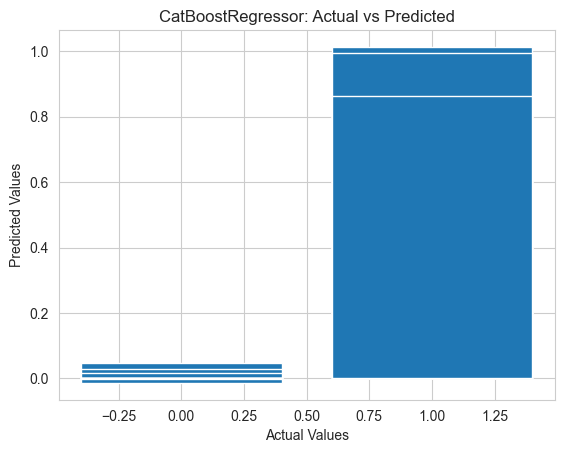

In [80]:
plt.bar(y_test, y_pred)
plt.xlabel('Actual Values') 
plt.ylabel('Predicted Values')
plt.title('CatBoostRegressor: Actual vs Predicted') 

<Axes: xlabel='failure_within_7_days'>

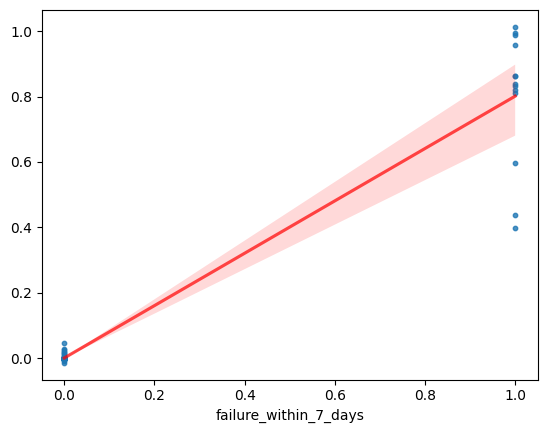

In [72]:
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red", "alpha": 0.7}, scatter_kws={"s": 10})

In [76]:
from catboost import CatBoostClassifier
# catboost_classifier = CatBoostClassifier()
# catboost_classifier.fit(X_train, y_train)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test) 
# from sklearn.metrics import accuracy_score
# accuracy_score(y_test, y_pred)  
# plt.figure(figsize=(10, 6))
# sns.set_style("whitegrid")      
# plt.scatter(y_test, y_pred, alpha=0.6)


In [77]:
catboost_model.predict(X_test)
# catboost_classifier.predict_proba(X_test)

array([ 8.82632667e-05,  1.31075915e-04, -2.08440843e-04, -5.58250837e-05,
        7.71367904e-04,  2.50937651e-04, -3.02379032e-05, -2.88145253e-04,
       -3.21847368e-05,  3.97398941e-01,  4.13136528e-04, -6.19949404e-04,
       -6.28957101e-04, -7.42237348e-04,  5.97597067e-01, -4.69152942e-04,
        1.23023532e-03,  2.32320972e-04,  8.62551457e-01,  4.38478379e-01,
       -2.35512511e-04, -5.58059971e-03,  4.10335134e-05,  6.53746984e-04,
        1.55172877e-03, -9.62293107e-04,  1.32589033e-04, -1.76764790e-05,
        9.88657834e-01, -7.50157688e-04, -1.06363908e-04,  8.70579281e-04,
        1.01313418e+00, -2.67474837e-04,  2.78187207e-04,  8.90844454e-05,
       -2.40318594e-03,  6.31736544e-04,  1.75934196e-04,  8.35272692e-04,
       -4.41022408e-04,  1.97422086e-04, -1.12031239e-04, -1.39801770e-03,
        1.16862137e-03, -1.21076910e-03, -3.00957767e-04, -3.77022208e-04,
       -8.12608025e-05,  7.00762193e-05,  1.92560874e-04, -3.77778993e-04,
       -7.10028622e-05, -

In [60]:
y_test # catboost_classifier.predict_proba(X_test)

521    0
737    0
740    0
660    0
411    0
      ..
408    0
332    0
208    0
613    0
78     0
Name: failure_within_7_days, Length: 200, dtype: int64

In [78]:
y_pred = catboost_model.predict(X_test)

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

<Axes: xlabel='failure_within_7_days'>

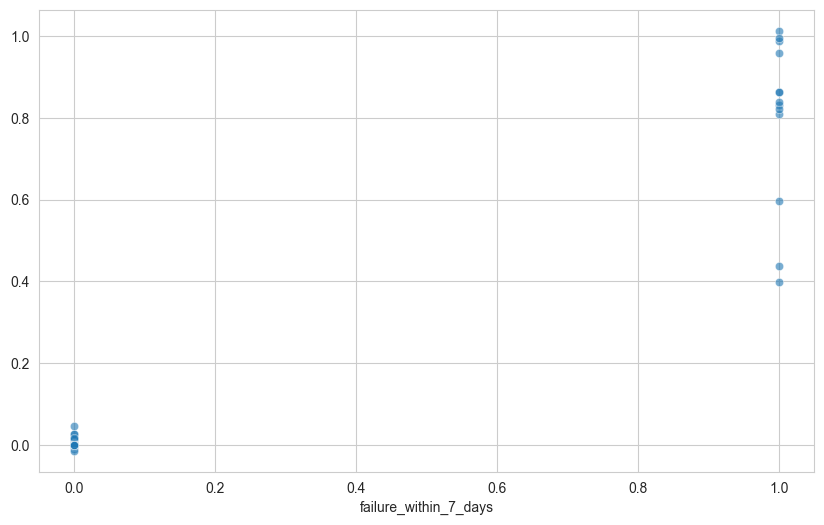

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6) 
     
# CatBoostRegressor
# CatBoostClassifier    


In [84]:
pred_df=pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'Difference': y_test - y_pred})
pred_df

,y_test,y_pred,Difference
521,0,0.000088,-0.000088
737,0,0.000131,-0.000131
740,0,-0.000208,0.000208
660,0,-0.000056,0.000056
411,0,0.000771,-0.000771
...,...,...,...
408,0,0.000589,-0.000589
332,0,0.000009,-0.000009
208,0,-0.013956,0.013956
613,0,-0.001391,0.001391
